# Tasselyzer Tutorial

**Author**: Chong Teng

**Updates by**: Haley Schuhl
**Updated on**: 18 December, 2024

Tasselyzer, a machine learning method to quantify anther extrusion in maize based on PlantCV.

In [1]:
# import packages
# inline to avoid interactive mode; widget to activate interactive mode;
%matplotlib inline
from plantcv import plantcv as pcv
import numpy as np
import os

The options class stands in for the command-line argument parser function used when running PlantCV workflows in parallel

In [2]:
# Input/output options
class options:
    def __init__(self):
        self.image = "2-6.jpg"  # required
        self.debug = "plot"  # None, "print" (save to file), or "plot" (display in notebook)
        self.writeimg = True
        self.result = "2-6.csv"  # required
        self.outdir = "." # Store the output to the current directory 
        self.pdfs = "out2_6.txt"

# Get options
args = options()

`pcv.params` can be used to set global parameters for PlantCV

In [3]:
# Set debug to the global parameter 
pcv.params.debug = args.debug
# Change display settings
pcv.params.dpi = 150
pcv.params.text_size = 10

Read in a color image

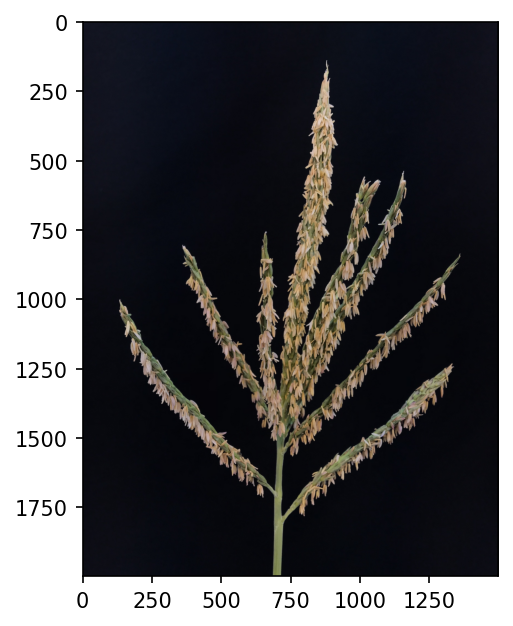

In [4]:
img, path, filename = pcv.readimage(filename=args.image)

Use the pretrained model to classify the pixels into three classes: the background (Dark), glum and branch (Green), and anthers (Anther)

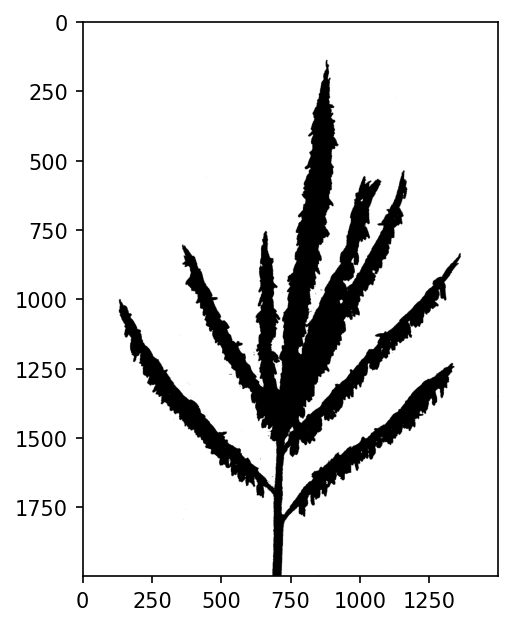

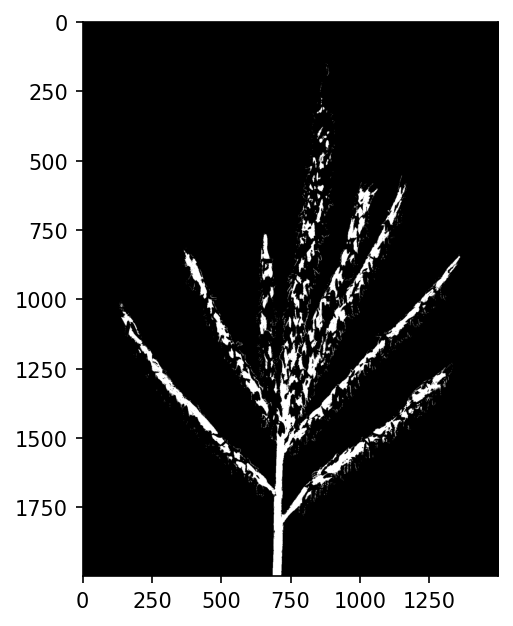

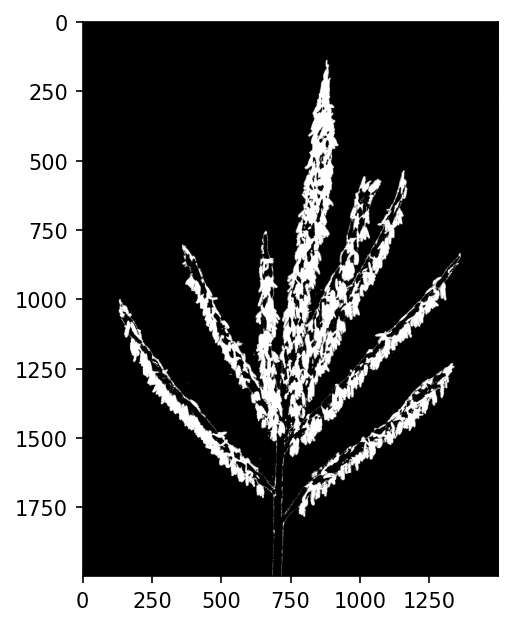

In [5]:
masks = pcv.naive_bayes_classifier(rgb_img=img, pdf_file=args.pdfs)

Overlay masks "Anther" and "Green" (Glum and branch)

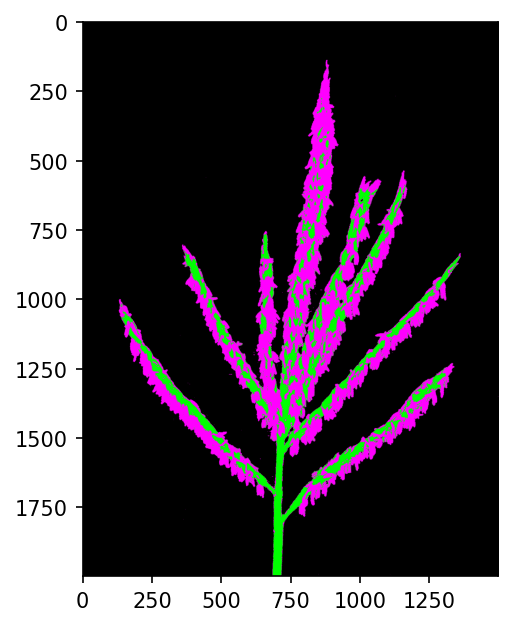

In [6]:
merged = pcv.visualize.colorize_masks(masks=[masks["Anther"], masks["Green"]], colors=["fuchsia", "green"])

Fill small objects for "Anther" to clean up the mask

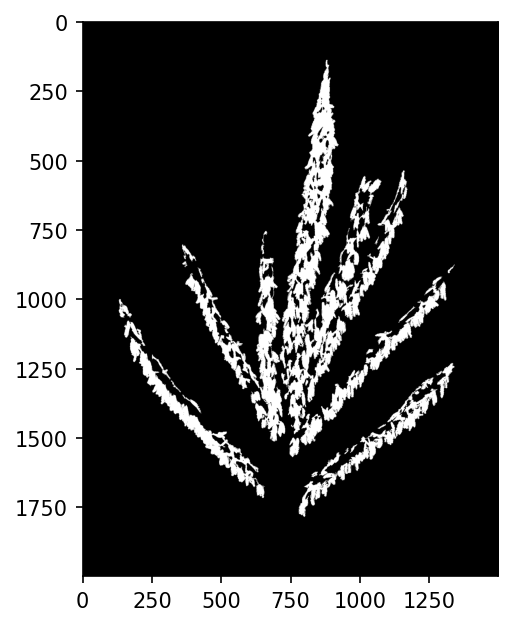

In [7]:
mask_anther = pcv.fill(bin_img=masks["Anther"], size=100)

Fill small objects for "Green" to clean up the mask

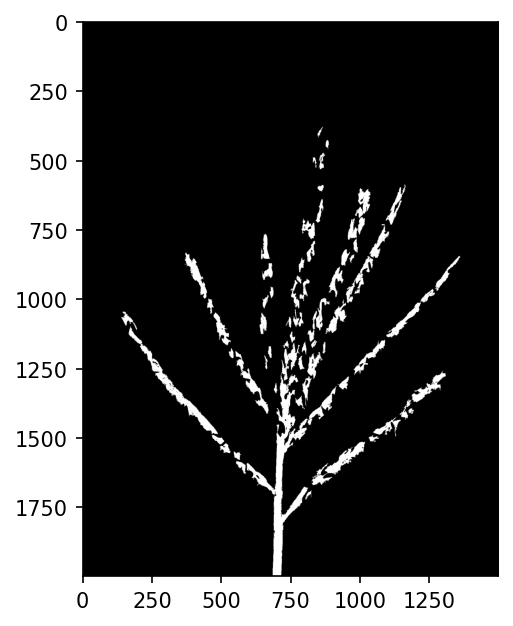

In [8]:
mask_glum = pcv.fill(bin_img=masks["Green"], size=200)

Create custom measurements:

```
anther_sum         = count of the number of pixels identified as anther
glum_branch_sum    = count of the number of pixels identified as glum and branch
anther_total_ratio = ratio of anther pixels to total anther + glum and branch pixels
```

Print out the results and save them as custom observations in PlantCV.

In [9]:
# ratio
anther_sum = np.count_nonzero(mask_anther)
glum_branch_sum = np.count_nonzero(mask_glum) 
anther_total_ratio = anther_sum / float(anther_sum + glum_branch_sum)
glum_branch_total_ratio = 1 - anther_total_ratio
print('anther sum', anther_sum)
print('glum and branch sum', glum_branch_sum)
print('anther total ratio', anther_total_ratio)
print('glum and branch to total ratio', glum_branch_total_ratio)

pcv.outputs.add_observation(sample="default", variable="anther_sum", trait="anther sum", method="PlantCV naive Bayes classifier", 
                            scale="pixels", datatype=int, value=anther_sum, label="pixels")
pcv.outputs.add_observation(sample="default", variable="glum_branch_sum", trait="glum and branch sum", method="PlantCV naive Bayes classifier", 
                            scale="pixels", datatype=int, value=glum_branch_sum, label="pixels")
pcv.outputs.add_observation(sample="default", variable="anther_total_ratio", trait="anther total ratio", method="PlantCV naive Bayes classifier", 
                            scale="pixels", datatype=float, value=anther_total_ratio, label="pixels")
pcv.outputs.add_observation(sample="default", variable="glum_branch_total_ratio", trait="glum and branch to total ratio", method="PlantCV naive Bayes classifier", 
                            scale="pixels", datatype=float, value=glum_branch_total_ratio, label="pixels")

anther sum 288453
glum and branch sum 128607
anther total ratio 0.6916342972234211
glum and branch to total ratio 0.30836570277657893


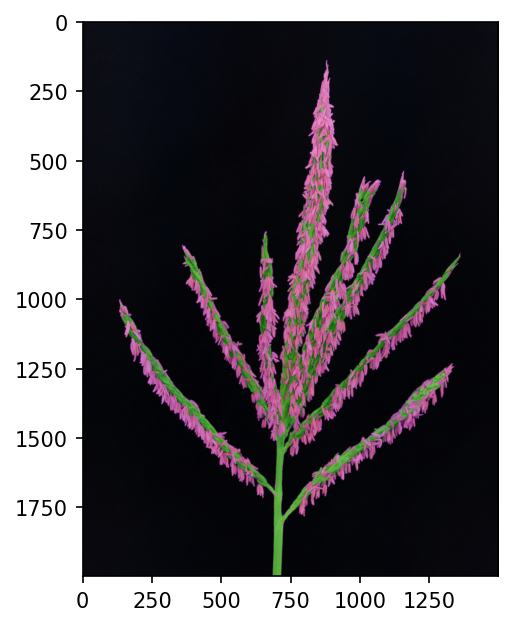

In [10]:
overlay = pcv.visualize.overlay_two_imgs(img1=img, img2=merged, alpha=0.7)

Save the results and overlay image. If running the workflow in parallel, change the output format to "json"

In [11]:
if args.writeimg:
    pcv.print_image(img=overlay, filename=os.path.join(args.outdir, f"overlay_{filename}"))
pcv.outputs.save_results(filename=args.result, outformat="csv")